Each software projects incorporates a specific technology stack. We aim to identify the **most common technology combinations** across open-source software projects.

Number of projects: 479
Processing ../data/projects/gin.json
Files in the project: []
['github action', 'yaml']
Processing ../data/projects/pdf.js.json
Error processing ../data/projects/pdf.js.json: Expecting property name enclosed in double quotes: line 250250266 column 7 (char 13817511936)
Processing ../data/projects/bilibili-API-collect.json
Files in the project: []
['yaml', 'github action', 'nodejs']
Processing ../data/projects/flash-attention.json
Files in the project: []
['yaml', 'github action', 'poetry', 'docker']
Processing ../data/projects/statsd.json
Files in the project: []
['github action', 'docker compose', 'yaml', 'nodejs', 'docker', 'json']


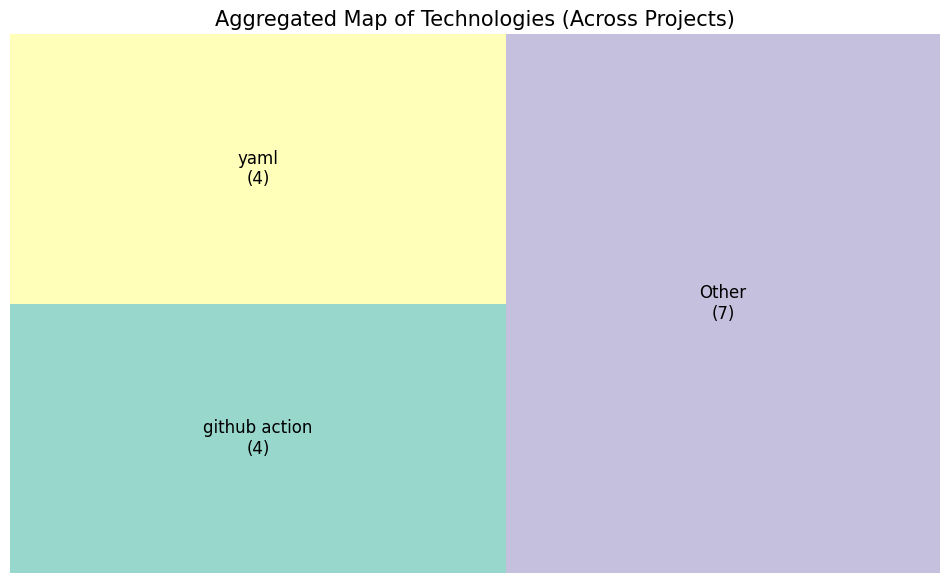

In [ ]:
from typing import List, Dict
import matplotlib.pyplot as plt
import squarify
import json
import glob

def plot_used_technologies(project_files: List):

    aggregated_concepts: Dict[str, int] = {}

    for project_file in project_files:
        print(f"Processing {project_file}")
        try:
            with open(project_file, "r", encoding="utf-8") as f:
                data = json.load(f)

                commit_data = data["commit_data"]

                latest_commit = next(filter(lambda commit: commit["is_latest_commit"] == True, commit_data), None)
                concepts = [" ".join(concept.split("-")) for concept in latest_commit["network_data"]["concepts"]]
            
                network_data = latest_commit["network_data"]["config_file_data"]
                files = [x["file_path"] for x in network_data if x["file_path"].endswith(".properties")]
                print("Files in the project:", files)


                print(concepts)

                for concept in concepts:  
                    if concept not in aggregated_concepts:
                        aggregated_concepts[concept] = 1    
                    else:   
                        aggregated_concepts[concept] += 1
        except Exception as e:
            # Handle any errors that occur during file reading or JSON parsing
            print(f"Error processing {project_file}: {e}")
            continue

    threshold = 3
    merged_concepts: Dict[str, int] = {}
    other_total = 0

    for concept, count in aggregated_concepts.items():
        if count >= threshold:
            merged_concepts[concept] = count
        else:
            other_total += count

    if other_total > 0:
        merged_concepts["Other"] = other_total


    # Prepare plot data
    #labels = [f"{c}\n({v})" for c, v in aggregated_concepts.items()]
    labels = [f"{c}\n({v})" for c, v in merged_concepts.items()]
    #sizes = list(aggregated_concepts.values())
    sizes = list(merged_concepts.values())
    colors = plt.cm.Set3.colors[:len(sizes)]

    # Plot
    plt.figure(figsize=(12, 7))
    squarify.plot(sizes=sizes, label=labels, color=colors, alpha=0.9, text_kwargs={'fontsize': 12})
    plt.axis('off')
    plt.title("Aggregated Map of Technologies (Across Projects)", fontsize=15)
    plt.show()


project_files = glob.glob("../data/projects/*.json")
print("Number of projects:", len(project_files))
plot_used_technologies(project_files[:5])


In [36]:
import json
import glob
import pandas as pd
import plotly.express as px
import numpy as np

# Ensure the dictionary is valid (commas fixed)
file_types = {
    "yaml": ["ansible", "ansible playbook", "kubernetes", "docker compose", "github action", "circleci", "elasticsearch", "flutter", "heroku", "spring", "travis", "yaml"],
    "properties": ["alluxio", "spring", "kafka", "gradle", "gradle wrapper", "maven wrapper", "properties"],
    "json": ["angular", "tsconfig", "nodejs", "cypress", "json"],
    "xml": ["maven", "android", "hadoop common", "hadoop hbase", "hadoop hdfs", "mapreduce", "yarn", "xml"],
    "toml": ["cargo", "netlify", "poetry", "toml"],
    "conf": ["mongodb", "nginx", "postgresql", "rabbitmq", "redis", "apache", "conf"],
    "ini": ["mysql", "php", "ini"],
    "cfg": ["zookeeper"],
    "other": ["docker", "django"]
}

custom_colors = [
    "#8dd3c7", "#ffffb3", "#bebada", "#fb8072",
    "#80b1d3", "#fdb462", "#b3de69", "#fccde5",
    "#d9d9d9", "#bc80bd", "#ccebc5", "#ffed6f"
]

# Reverse the mapping: concept → file type
concept_to_filetype = {}
for ext, concepts in file_types.items():
    for concept in concepts:
        concept_to_filetype[concept.lower()] = ext

def plot_technology_by_filetype(project_files):
    tech_counts = {}

    for project_file in project_files:
        print(f"Processing {project_file}")
        try:
            with open(project_file, "r", encoding="utf-8") as f:
                data = json.load(f)
                latest_commit = next(
                    filter(lambda commit: commit["is_latest_commit"] == True, data["commit_data"]), None
                )

                config_data = latest_commit["network_data"]["config_file_data"]

                for config_file in config_data:
                    raw_concept = config_file["concept"]
                    normalized_concept = " ".join(raw_concept.lower().split("-")).strip()
                    file_type = concept_to_filetype.get(normalized_concept, "other")

                    # Rename technology to 'Other' only if concept exactly equals file_type
                    concept_label = "other" if normalized_concept == file_type else normalized_concept

                    print(f"File Type: {file_type}, Technology: {concept_label}")

                    key = (file_type, concept_label)
                    tech_counts[key] = tech_counts.get(key, 0) + 1

        except Exception as e:
            print(f"Error processing {project_file}: {e}")
            continue

    data_for_df = []
    for (file_type, concept), count in tech_counts.items():
        data_for_df.append({
            "File Type": file_type,
            "Technology": concept,
            "Count": count
        })

    df = pd.DataFrame(data_for_df)

    # Log-scaling for visualization
    df["Scaled Count"] = df["Count"].apply(lambda x: np.log1p(x))  # log(1 + x)

    # Optional: Enrich label for display
    df["Label"] = df["Technology"] + " (" + df["Count"].astype(str) + ")"
    
    # Plot
    fig = px.treemap(
        df,
        path=["File Type", "Label"],
        values="Scaled Count",
        color="File Type",
        color_discrete_sequence=custom_colors,
        title="Technology Usage by File Type"
    )

    fig.update_traces(root_color="lightgrey", textfont=dict(family="Arial Bold, Arial, sans-serif", size=14, color="black"))
    fig.update_layout(
        width=1200,
        height=800,
        margin=dict(t=50, l=25, r=25, b=25)
    )
    fig.show()

# Example usage
project_files = glob.glob("../data/projects/*.json")
plot_technology_by_filetype(project_files[:5])


Processing ../data/projects/gin.json
File Type: yaml, Technology: other
File Type: yaml, Technology: github action
File Type: yaml, Technology: github action
File Type: yaml, Technology: github action
File Type: yaml, Technology: other
File Type: yaml, Technology: other
File Type: yaml, Technology: other
Processing ../data/projects/bilibili-API-collect.json
File Type: yaml, Technology: other
File Type: yaml, Technology: other
File Type: yaml, Technology: other
File Type: yaml, Technology: other
File Type: yaml, Technology: other
File Type: yaml, Technology: github action
File Type: json, Technology: nodejs
Processing ../data/projects/flash-attention.json
File Type: yaml, Technology: github action
File Type: toml, Technology: poetry
File Type: other, Technology: docker
File Type: toml, Technology: poetry
File Type: other, Technology: docker
File Type: yaml, Technology: other
File Type: yaml, Technology: other
File Type: yaml, Technology: other
File Type: yaml, Technology: other
File Typ

Memberships: [('github-action', 'yaml'), ('json', 'yaml'), ('github-action', 'json'), ('github-action', 'json', 'yaml'), ('nodejs', 'yaml'), ('github-action', 'nodejs'), ('json', 'nodejs'), ('github-action', 'nodejs', 'yaml'), ('json', 'nodejs', 'yaml'), ('docker', 'yaml'), ('github-action', 'json', 'nodejs'), ('github-action', 'json', 'nodejs', 'yaml'), ('docker', 'json'), ('docker', 'json', 'yaml'), ('docker', 'github-action'), ('docker', 'github-action', 'yaml'), ('toml', 'yaml'), ('json', 'tsconfig'), ('nodejs', 'tsconfig'), ('tsconfig', 'yaml')]
Counts: [86, 74, 67, 64, 47, 41, 41, 41, 41, 37, 35, 35, 35, 33, 32, 31, 30, 29, 29, 29]


/Users/sebastiansimon/GitHub/config-space/env/lib/python3.12/site-packages/upsetplot/data.py:303: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/Users/sebastiansimon/GitHub/config-space/env/lib/python3.12/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original o

<Figure size 1000x600 with 0 Axes>

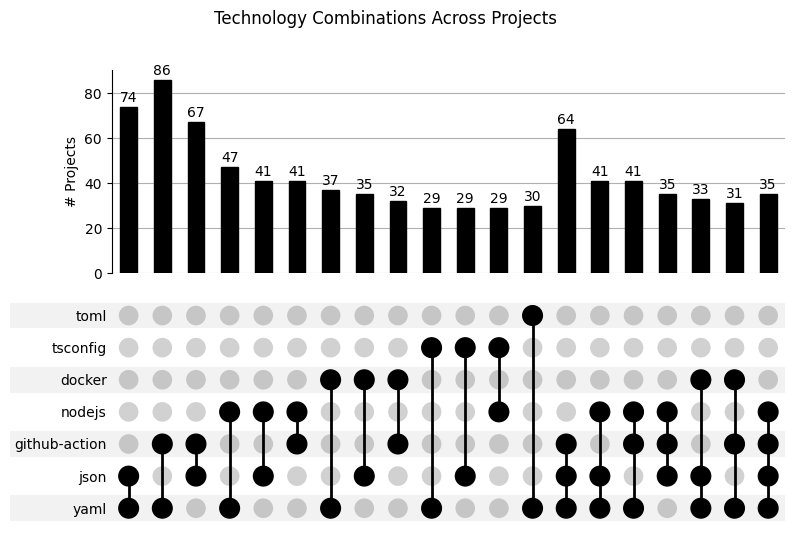

In [5]:
from upsetplot import UpSet, from_memberships
import matplotlib.pyplot as plt

def plot_technology_combinations(combos_counter: Counter, num_combos: int = 20):
    memberships = []
    counts = []

    for combo, count in combos_counter.most_common(num_combos):
        memberships.append(combo)
        counts.append(count)

    print("Memberships:", memberships)
    print("Counts:", counts)

    data = from_memberships(memberships, data=counts)

    # Plot
    plt.figure(figsize=(10, 6))
    plot = UpSet(data, show_counts=True, element_size=None, totals_plot_elements=0).plot()
    plot["intersections"].set_ylabel("# Projects")
    plt.suptitle("Technology Combinations Across Projects")
    plt.show()

plot_technology_combinations(combos_counter, num_combos=20)

In [ ]:
import os
import json
import pandas as pd
import glob


TECHNOLOGIES_NOT_COVERED = {
    "dependabot.yml": "dependabot",
    "golangco.yml": "golangci-lint",
    "goreleaser.yaml": "goreleaser",
    "codecov.yml": "codecov",
    "package-lock.json": "nodejs",
    "pkgr.yml": "pkgr",
    "tsconfig.base.json": "typescript",
    "eslint.json": "eslint",
    "turbo.json": "turborepo",
    "yarnrc.yml": "yarn"
}


def get_concepts_from_file_data(file_data):
    if file_data["concept"] in ["json", "yaml"]:
        file_name = file_data["file_path"]
        if file_name in TECHNOLOGIES_NOT_COVERED:
            return TECHNOLOGIES_NOT_COVERED[file_name]
        else:
            return file_data["concept"]
    return file_data["concept"]


def extract_latest_commit_data(json_data):
    # Fallback to the last commit if no latest is explicitly marked
    latest_commit = next((c for c in json_data["commit_data"] if c.get("is_latest_commit")), None)
    if not latest_commit and json_data["commit_data"]:
        latest_commit = json_data["commit_data"][-1]
    return latest_commit

def analyze_project_file(filepath):
    with open(filepath, 'r') as f:
        data = json.load(f)
    
    latest_commit = extract_latest_commit_data(data)
    if not latest_commit:
        return []

    #concepts = latest_commit["network_data"].get("concepts", [])
    config_files = latest_commit["network_data"].get("config_file_data", [])
    concepts = [get_concepts_from_file_data(file) for file in config_files]

    print(concepts)

    file_options = [f.get("options", 0) for f in config_files]
    avg_options = round(sum(file_options) / len(file_options), 2) if file_options else 0

    result = []
    for concept in set(concepts):
        files_for_concept = [f for f in config_files if get_concepts_from_file_data(f) == concept]
        file_count = len(files_for_concept)
        total_options = sum(f.get("options", 0) for f in files_for_concept)
        avg_options = round(total_options / file_count, 2) if file_count else 0

        # Debugging output
        #if concept == "nodejs":
        #    print("Project: ", filepath)
        #    for file in files_for_concept:
        #        print(file["file_path"])

        # Debugging
        #if concept == "yaml" or concept == "json":
        #    print(filepath)
        #    for file in files_for_concept:
        #        print(file["file_path"])

        result.append({
            "Project": data.get("project_name", os.path.basename(filepath)),
            "Technology": concept,
            "File Count": file_count,
            "Average Options per File": avg_options
        })
    return result

    

def analyze_all_projects(project_files):
    aggregated_data = []
    for file_name in project_files:
        aggregated_data.extend(analyze_project_file(file_name))
    return pd.DataFrame(aggregated_data)


project_files = glob.glob("../data/projects/*.json")  # Replace with your actual path
df = analyze_all_projects(project_files[:5])

# Calculate average files per technology per project
tech_proj_file_counts = df.groupby(["Technology", "Project"])["File Count"].sum().reset_index()
avg_files_per_tech_per_proj = tech_proj_file_counts.groupby("Technology")["File Count"].mean().round(2)
avg_files_per_tech_per_proj.name = "Avg_Files_Per_Project"

# Save to CSV or display
df_grouped = df.groupby("Technology").agg(
    Usage_Count=("Technology", "count"),
    Total_Projects=("Project", "nunique"),
    Avg_Options_Per_File=("Average Options per File", "mean"),
    Total_Files=("File Count", "sum")
).reset_index()

df_grouped["Avg_Options_Per_File"] = df_grouped["Avg_Options_Per_File"].round(2)
df_grouped = df_grouped.merge(avg_files_per_tech_per_proj, on="Technology")

print(df_grouped.to_string(index=False))
df_grouped.to_csv("tech_composition_summary.csv", index=False)


['yaml', 'github-action', 'github-action', 'github-action', 'yaml', 'yaml', 'codecov']
['yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'github-action', 'nodejs']
Project:  ../data/projects/bilibili-API-collect.json
package.json
['github-action', 'poetry', 'docker', 'poetry', 'docker', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', 'yaml', '